# King County House Sales Regression Analysis
## Data Modeling

* Student name: Spencer Hadel
* Student pace: Flex
* Scheduled project review date/time: 5/16/22 12:30PM EST
* Instructor name: Claude Fried

#### Objective

In order to help a new real estate company in King County, we need to analyze past house sales data in the region and create a linear regression model which can help the company better understand what factors contribute to price of a given home. We will import over 20 thousand data points from recent sales in the King County area, and proceed to clean, preprocess, and model the information present in this dataset in order to inform the new company on how to appropriately assess the value of a home when helping a client buy or sell a home.

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

### Import Prepared Data from kc_preprocessing_exploring.ipynb

We have already preprocessed our data in the kc_kc_preprocessing_exploring notebook:

[Preprocessing Notebook](./kc_preprocessing_exploring.ipynb)

In [2]:
df = pd.read_csv('./data/preprocessed.csv', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21532 entries, 0 to 21596
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21532 non-null  float64
 1   sqft_living          21532 non-null  float64
 2   sqft_lot             21532 non-null  float64
 3   yr_built             21532 non-null  float64
 4   bedrooms             21532 non-null  float64
 5   bathrooms            21532 non-null  float64
 6   floors               21532 non-null  float64
 7   renovated_2000       21532 non-null  int64  
 8   waterfront           21532 non-null  int64  
 9   has_basement         21532 non-null  int64  
 10  view_EXCELLENT       21532 non-null  int64  
 11  view_FAIR            21532 non-null  int64  
 12  view_GOOD            21532 non-null  int64  
 13  view_NONE            21532 non-null  int64  
 14  grade_11 Excellent   21532 non-null  int64  
 15  grade_12 Luxury      21532 non-null 

In [4]:
subs = [(' ', '_'),('.','_'),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

list(df.columns)

['price',
 'sqft_living',
 'sqft_lot',
 'yr_built',
 'bedrooms',
 'bathrooms',
 'floors',
 'renovated_2000',
 'waterfront',
 'has_basement',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'view_NONE',
 'grade_11_Excellent',
 'grade_12_Luxury',
 'grade_13_Mansion',
 'grade_3_Poor',
 'grade_4_Low',
 'grade_5_Fair',
 'grade_6_Low_Average',
 'grade_7_Average',
 'grade_8_Good',
 'grade_9_Better',
 'condition_Fair',
 'condition_Good',
 'condition_Poor',
 'condition_Very_Good']

## Split, Train and Test Data

Now that we have a complete preprocessed dataset, we need to split the data into train and test datasets, as well as identify the feature we are testing for: price.

In [5]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#check size of each
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16149, 27), (5383, 27), (16149,), (5383,))

In [6]:
X_1 = X_train
y = y_train

model_1_orig = sm.OLS(y, sm.add_constant(X_1)).fit()
model_1_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1229.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        12:13:44   Log-Likelihood:            -2.2098e+05
No. Observations:               16149   AIC:                         4.420e+05
Df Residuals:                   16122   BIC:                         4.422e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9.769e+05   1.14e+04     85.749      0.000    9.55e+05    9.99e+05
sqft_living          1.013e+05   3877.148     26.129      0.000    9.37e+04    1.09e+05
sqft_lot             -2.64e+04   2105.860    -12.538      0.000   -3.05e+04   -2.23e+04
yr_built            -8.491e+04   2370.576    -35.820      0.000   -8.96e+04   -8.03e+04
bedrooms            -1.626e+04   2312.328     -7.032      0.000   -2.08e+04   -1.17e+04
bathrooms             2.29e+04   3118.733      7.341      0.000    1.68e+04     2.9e+04
floors               1.179e+04   2478.541      4.758      0.000    6933.505    1.66e+04
renovated_2000       1.069e+05   1.32e+04      8.083      0.000     8.1e+04    1.33e+05
waterfront           5.722e+05   2.45e+04     23.347      0.000    5.24e+05     6.2e+05
has_basement         1.896e+04   4248.492      4.462      0.000    1.06e+04    2.73e+04
view_EXCELLENT       2.333e+05   1.87e+04     12.501      0.000    1.97e+05     2.7e+05
view_FAIR            6.961e+04   1.59e+04      4.389      0.000    3.85e+04    1.01e+05
view_GOOD            4.061e+04   1.38e+04      2.942      0.003    1.36e+04    6.77e+04
view_NONE           -6.925e+04   8344.124     -8.299      0.000   -8.56e+04   -5.29e+04
grade_11_Excellent    3.65e+05   1.46e+04     25.014      0.000    3.36e+05    3.94e+05
grade_12_Luxury      9.057e+05   2.63e+04     34.391      0.000    8.54e+05    9.57e+05
grade_13_Mansion     1.853e+06   6.47e+04     28.650      0.000    1.73e+06    1.98e+06
grade_3_Poor         3.469e-10   2.51e-11     13.823      0.000    2.98e-10    3.96e-10
grade_4_Low         -5.459e+05   4.83e+04    -11.308      0.000   -6.41e+05   -4.51e+05
grade_5_Fair        -6.103e+05   1.93e+04    -31.561      0.000   -6.48e+05   -5.72e+05
grade_6_Low_Average  -5.67e+05   1.18e+04    -47.936      0.000    -5.9e+05   -5.44e+05
grade_7_Average     -5.081e+05   9396.258    -54.077      0.000   -5.27e+05    -4.9e+05
grade_8_Good        -4.104e+05   8573.286    -47.868      0.000   -4.27e+05   -3.94e+05
grade_9_Better      -2.312e+05   8794.965    -26.293      0.000   -2.48e+05   -2.14e+05
condition_Fair      -1.534e+04   1.97e+04     -0.780      0.436   -5.39e+04    2.32e+04
condition_Good        2.09e+04   4201.396      4.976      0.000    1.27e+04    2.91e+04
condition_Poor      -3.825e+04   4.47e+04     -0.857      0.392   -1.26e+05    4.93e+04
condition_Very_Good  6.321e+04   6815.647      9.274      0.000    4.98e+04    7.66e+04
==============================================================================
Omnibus:                    11167.403   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           681451.840
Skew:                           2.679   Prob(JB):                         0.00
Kurtosis:                      34.369  

### Remove Uninfluential Features

The first issue with our model is the number of features. This much potential noise is likely not helping our model properly train itself on the relevant data.

As our first approach, we use scikit-learn's feature_selection submodule to select only the most important features.

In [7]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

# Instantiate and fit the selector
selector = RFECV(LinearRegression(), cv=ShuffleSplit(n_splits=3, test_size=0.25, random_state=0))
selector.fit(X_train_for_RFECV, y_train)

selected_features = []

# Relevant Features:
for index, col in enumerate(X_train.columns):
    if selector.support_[index] == True:
        selected_features.append(col)
        #print(col)

print(selected_features)

['sqft_living', 'sqft_lot', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'renovated_2000', 'waterfront', 'has_basement', 'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'view_NONE', 'grade_11_Excellent', 'grade_12_Luxury', 'grade_13_Mansion', 'grade_4_Low', 'grade_5_Fair', 'grade_6_Low_Average', 'grade_7_Average', 'grade_8_Good', 'grade_9_Better', 'condition_Good', 'condition_Very_Good']


In [8]:
dropped = X_train.drop(selected_features, axis=1)

#see what features were removed
dropped.columns

Index(['grade_3_Poor', 'condition_Fair', 'condition_Poor'], dtype='object')

Now we rerun the model with only the feature_selector's most important features.

In [9]:
X_2 = X_train[selected_features]

model_2_remove_uninfluential = sm.OLS(y, sm.add_constant(X_2)).fit()
model_2_remove_uninfluential.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1332.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        12:13:45   Log-Likelihood:            -2.2098e+05
No. Observations:               16149   AIC:                         4.420e+05
Df Residuals:                   16124   BIC:                         4.422e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9.768e+05   1.14e+04     85.745      0.000    9.54e+05    9.99e+05
sqft_living          1.014e+05   3875.478     26.168      0.000    9.38e+04    1.09e+05
sqft_lot            -2.653e+04   2102.052    -12.621      0.000   -3.07e+04   -2.24e+04
yr_built            -8.473e+04   2365.148    -35.826      0.000   -8.94e+04   -8.01e+04
bedrooms            -1.626e+04   2312.277     -7.033      0.000   -2.08e+04   -1.17e+04
bathrooms            2.285e+04   3118.365      7.327      0.000    1.67e+04     2.9e+04
floors               1.179e+04   2478.486      4.757      0.000    6932.183    1.66e+04
renovated_2000       1.073e+05   1.32e+04      8.120      0.000    8.14e+04    1.33e+05
waterfront           5.718e+05   2.45e+04     23.336      0.000    5.24e+05     6.2e+05
has_basement         1.895e+04   4247.637      4.460      0.000    1.06e+04    2.73e+04
view_EXCELLENT       2.333e+05   1.87e+04     12.500      0.000    1.97e+05     2.7e+05
view_FAIR            6.943e+04   1.59e+04      4.379      0.000    3.83e+04    1.01e+05
view_GOOD            4.054e+04   1.38e+04      2.937      0.003    1.35e+04    6.76e+04
view_NONE           -6.935e+04   8343.469     -8.312      0.000   -8.57e+04    -5.3e+04
grade_11_Excellent    3.65e+05   1.46e+04     25.015      0.000    3.36e+05    3.94e+05
grade_12_Luxury      9.057e+05   2.63e+04     34.394      0.000    8.54e+05    9.57e+05
grade_13_Mansion     1.853e+06   6.47e+04     28.650      0.000    1.73e+06    1.98e+06
grade_4_Low         -5.502e+05   4.81e+04    -11.434      0.000   -6.45e+05   -4.56e+05
grade_5_Fair         -6.12e+05   1.93e+04    -31.756      0.000    -6.5e+05   -5.74e+05
grade_6_Low_Average -5.673e+05   1.18e+04    -47.984      0.000    -5.9e+05   -5.44e+05
grade_7_Average     -5.082e+05   9395.871    -54.085      0.000   -5.27e+05    -4.9e+05
grade_8_Good        -4.104e+05   8573.022    -47.872      0.000   -4.27e+05   -3.94e+05
grade_9_Better      -2.313e+05   8794.727    -26.298      0.000   -2.49e+05   -2.14e+05
condition_Good       2.137e+04   4178.168      5.115      0.000    1.32e+04    2.96e+04
condition_Very_Good  6.373e+04   6798.171      9.375      0.000    5.04e+04    7.71e+04
==============================================================================
Omnibus:                    11163.723   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           680928.671
Skew:                           2.678   Prob(JB):                         0.00
Kurtosis:                      34.357   Cond. No.                         67.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This has automaticallt removed all p values above the threshold of 0.05, which is good as we do not have to do it manually. 

This also yielded roughly the same R squared score, which is good because it means the features we removed were in fact very inconsequential to the outcome of our model.

### Investigate Multicollinearity

The Cond. No is above 30 (which indicates strong multicollinearity) the next step is to check our features for multicollinearity, and remove any features that may be impacting each other in a way that trains our model incorrectly.

We need to investigate which features are the most correlated, and then decide which of these to remove from the data in order to prevent multicollinearity

In [10]:
corr = X_2.corr()
corr

,sqft_living,sqft_lot,yr_built,bedrooms,bathrooms,floors,renovated_2000,waterfront,has_basement,view_EXCELLENT,...,grade_12_Luxury,grade_13_Mansion,grade_4_Low,grade_5_Fair,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,condition_Good,condition_Very_Good
sqft_living,1.000000,0.328794,0.351948,0.652068,0.763292,0.396071,0.044469,0.085463,0.233090,0.143397,...,0.163094,0.077641,-0.090868,-0.185671,-0.391861,-0.324112,0.151246,0.330490,-0.080506,-0.017627
sqft_lot,0.328794,1.000000,-0.006077,0.202972,0.087826,-0.214441,-0.008913,0.074727,-0.048784,0.078648,...,0.101295,0.031110,0.012768,0.021118,-0.019279,-0.075455,-0.098942,0.076658,0.125449,-0.005572
yr_built,0.351948,-0.006077,1.000000,0.199792,0.534953,0.474481,-0.123900,-0.021563,-0.164290,-0.016140,...,0.051074,0.008263,-0.044038,-0.131708,-0.311836,-0.213763,0.204457,0.216458,-0.256292,-0.245297
bedrooms,0.652068,0.202972,0.199792,1.000000,0.540399,0.217331,0.034062,-0.006333,0.155752,0.030981,...,0.060345,0.033005,-0.101529,-0.152520,-0.278843,-0.091307,0.093047,0.164031,-0.018454,0.025917
bathrooms,0.763292,0.087826,0.534953,0.540399,1.000000,0.512944,0.057632,0.050733,0.167496,0.094384,...,0.118855,0.055679,-0.072295,-0.165777,-0.415466,-0.289404,0.241611,0.265774,-0.161818,-0.026405
floors,0.396071,-0.214441,0.474481,0.217331,0.512944,1.000000,0.010760,0.020177,-0.256180,0.024337,...,0.061472,0.019804,-0.030868,-0.082200,-0.238386,-0.310077,0.195754,0.254673,-0.260746,-0.120948
renovated_2000,0.044469,-0.008913,-0.123900,0.034062,0.057632,0.010760,1.000000,0.017132,0.047421,0.011312,...,-0.001769,0.014715,-0.004793,-0.009943,-0.008929,-0.033319,0.014149,0.031984,-0.067685,-0.033205
waterfront,0.085463,0.074727,-0.021563,-0.006333,0.050733,0.020177,0.017132,1.000000,0.039966,0.572790,...,0.094273,-0.002201,-0.003043,0.018527,-0.007057,-0.051163,-0.013756,0.005677,0.004901,0.022545
has_basement,0.233090,-0.048784,-0.164290,0.155752,0.167496,-0.256180,0.047421,0.039966,1.000000,0.078960,...,0.014115,0.018455,-0.024929,-0.069903,-0.096761,0.054380,0.042994,-0.033681,0.074747,0.097779
view_EXCELLENT,0.143397,0.078648,-0.016140,0.030981,0.094384,0.024337,0.011312,0.572790,0.078960,1.000000,...,0.130655,0.055896,-0.004413,0.005976,-0.023755,-0.080622,-0.020074,0.044152,0.011896,0.031759


In [11]:
sns.set(rc = {'figure.figsize':(20,20)})

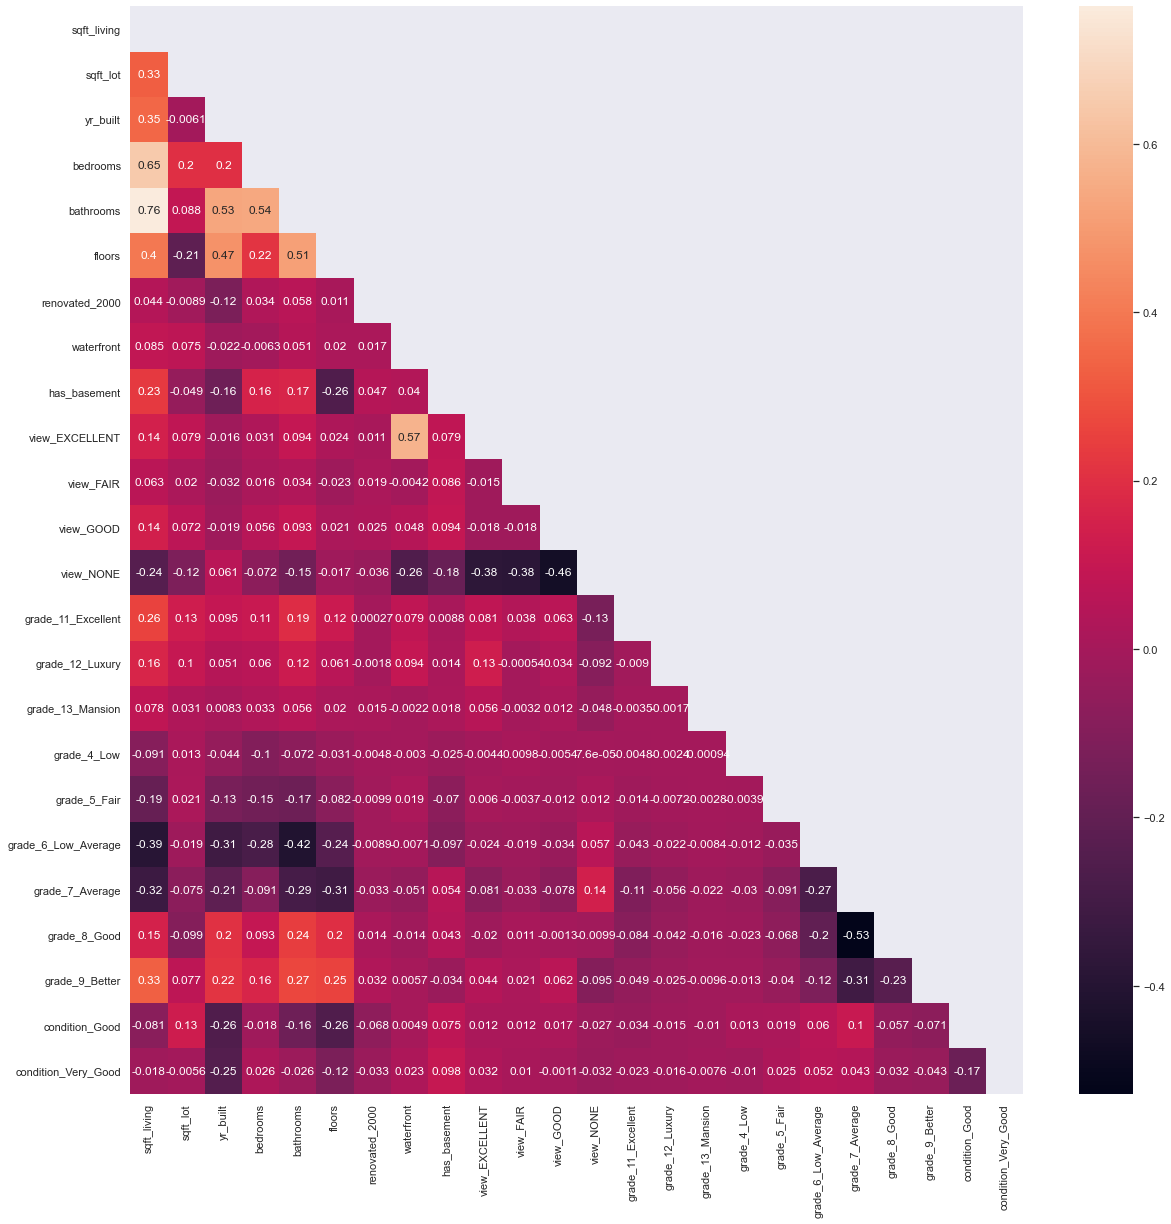

In [12]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot = True, mask=mask);

plt.savefig('./img/corr_heatmap')

We still have far too many features to just visually identify which combinations are contributing the most to multicollinearity. 

In [13]:
#remove correlation of features with themselves
corr = corr[corr < 1]

#top positively correlated
corr[corr < 1].unstack().sort_values(ascending=False)[:20]

sqft_living     bathrooms         0.763292
bathrooms       sqft_living       0.763292
bedrooms        sqft_living       0.652068
sqft_living     bedrooms          0.652068
waterfront      view_EXCELLENT    0.572790
view_EXCELLENT  waterfront        0.572790
bedrooms        bathrooms         0.540399
bathrooms       bedrooms          0.540399
                yr_built          0.534953
yr_built        bathrooms         0.534953
bathrooms       floors            0.512944
floors          bathrooms         0.512944
                yr_built          0.474481
yr_built        floors            0.474481
floors          sqft_living       0.396071
sqft_living     floors            0.396071
                yr_built          0.351948
yr_built        sqft_living       0.351948
grade_9_Better  sqft_living       0.330490
sqft_living     grade_9_Better    0.330490
dtype: float64

The above list of values shows the most positively correlated pairings of features. Ideally we would remove one of each of the features with the strongest collinearity.

We can see that things like bedrooms and sqftliving are strongly correlated. We can experiment with removing these features later, but for now we keep them because they are recognizable as potentially important features of the pricing of a home.

We want to remove features we see a many times, and can probably attempt to remove bathrooms, as they are a strongly correlated feature with both sqft_living and bedrooms, which makes sense in real-life terms as well (larger homes with more bedrooms are likely to have more bathrooms, etc). Similarly, we can try removing view_excellent because it seems to heavily correlate with being on a waterfront.

In [14]:
items_to_drop = ['bathrooms', 'view_EXCELLENT', 'floors']

In [15]:
#negatively correlated
corr.unstack().sort_values(ascending=True)[:20]

grade_8_Good         grade_7_Average       -0.528170
grade_7_Average      grade_8_Good          -0.528170
view_NONE            view_GOOD             -0.461765
view_GOOD            view_NONE             -0.461765
grade_6_Low_Average  bathrooms             -0.415466
bathrooms            grade_6_Low_Average   -0.415466
sqft_living          grade_6_Low_Average   -0.391861
grade_6_Low_Average  sqft_living           -0.391861
view_NONE            view_FAIR             -0.377216
view_FAIR            view_NONE             -0.377216
view_NONE            view_EXCELLENT        -0.375617
view_EXCELLENT       view_NONE             -0.375617
sqft_living          grade_7_Average       -0.324112
grade_7_Average      sqft_living           -0.324112
yr_built             grade_6_Low_Average   -0.311836
grade_6_Low_Average  yr_built              -0.311836
grade_7_Average      floors                -0.310077
floors               grade_7_Average       -0.310077
grade_7_Average      grade_9_Better        -0.

Next, doing the same thing with negatively correlated values (values which inverseley strongly affect each other), we'll try getting rid of grade_7_average, grade_6_low_average, and view_none.

In [16]:
items_to_drop.extend(['grade_7_Average', 'grade_6_Low_Average', 'view_NONE'])
items_to_drop

['bathrooms',
 'view_EXCELLENT',
 'floors',
 'grade_7_Average',
 'grade_6_Low_Average',
 'view_NONE']

Now that we have checked for uninfluential features as well as features potentially causing multicollinearity, we run the tests again.

In [17]:
X_3 = X_2.drop(items_to_drop, axis=1)

model_3_remove_corr = sm.OLS(y, sm.add_constant(X_3)).fit()
model_3_remove_corr.rsquared

0.5865411709780006

This decreased out our R-squared value, which is not necessarily a problem. We will try a few more things before we compare each model's RMSE.

Before comparing all of our models ability to accurately predict data on the training and testing sets, we will create a feature set based on our observations in the preprocessing phase and create a model for it as well. We will try removing the categorical variables as well.

We will look at the correlation between each feature and price from the preprocessed model as a guide.

In [18]:
#absolute values because negative correlation still counts
price_corr = abs(df.corr()['price']).sort_values(ascending = False)
price_corr

price                  1.000000
sqft_living            0.612307
bathrooms              0.456159
view_NONE              0.358317
grade_11_Excellent     0.358260
grade_7_Average        0.316746
view_EXCELLENT         0.304676
bedrooms               0.298957
grade_12_Luxury        0.284766
floors                 0.266977
waterfront             0.259221
grade_9_Better         0.237307
grade_13_Mansion       0.212891
grade_6_Low_Average    0.209958
view_GOOD              0.183964
has_basement           0.177574
sqft_lot               0.161755
renovated_2000         0.106630
view_FAIR              0.093149
grade_5_Fair           0.084907
condition_Very_Good    0.057646
yr_built               0.053036
condition_Fair         0.051632
condition_Good         0.031997
grade_4_Low            0.031754
condition_Poor         0.019962
grade_3_Poor           0.005176
grade_8_Good           0.005142
Name: price, dtype: float64

In [19]:
#just take the top correlated features with price
observed_features = price_corr.index[1:11]

X_4 = X_train[observed_features]

model_4_price_corr = sm.OLS(y, sm.add_constant(X_4)).fit()
model_4_price_corr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1943.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        12:13:51   Log-Likelihood:            -2.2342e+05
No. Observations:               16149   AIC:                         4.469e+05
Df Residuals:                   16138   BIC:                         4.469e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               6.901e+05   7159.992     96.388      0.000    6.76e+05    7.04e+05
sqft_living          1.82e+05   3582.647     50.809      0.000    1.75e+05    1.89e+05
bathrooms          -5905.8362   3226.278     -1.831      0.067   -1.22e+04     418.026
view_NONE          -1.589e+05   7358.669    -21.597      0.000   -1.73e+05   -1.44e+05
grade_11_Excellent   5.37e+05   1.54e+04     34.834      0.000    5.07e+05    5.67e+05
grade_7_Average    -7.014e+04   4331.541    -16.193      0.000   -7.86e+04   -6.17e+04
view_EXCELLENT      2.815e+05   2.06e+04     13.658      0.000    2.41e+05    3.22e+05
bedrooms           -2.769e+04   2643.859    -10.475      0.000   -3.29e+04   -2.25e+04
grade_12_Luxury     1.012e+06   2.98e+04     33.905      0.000    9.53e+05    1.07e+06
floors               1.03e+04   2322.722      4.434      0.000    5746.275    1.49e+04
waterfront          5.254e+05   2.84e+04     18.504      0.000     4.7e+05    5.81e+05
==============================================================================
Omnibus:                    11743.658   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           705984.762
Skew:                           2.909   Prob(JB):                         0.00
Kurtosis:                      34.865   Cond. No.                         26.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluating Models
Next we will compare the RMSE for models from each set of features we explored, on both the training and testing data.

The RMSE, or Root Mean Squared Error, is a measure of how far off our regression models are from the actual values they attempt to predict. The lower the RMSE, the better at predicting prices the trained model is.

In [20]:
#training linear regression models on the training set for each set of features

#X_1
#train model
model1 = LinearRegression().fit(X_1, y_train)
#predict on model
pred1 = model1.predict(X_1)
#rmse for training set
train1_rmse = mean_squared_error(y_train, pred1, squared=False)

#create test set of features
X_1_test = X_test[X_1.columns]
#predict on test feature set
pred1_test = model1.predict(X_1_test)
#rmse for test set
test1_rmse = mean_squared_error(y_test, pred1_test, squared=False)

#X_2
model2 = LinearRegression().fit(X_2, y_train)
pred2 = model2.predict(X_2)
train2_rmse = mean_squared_error(y_train, pred2, squared=False)

X_2_test = X_test[X_2.columns]
pred2_test = model2.predict(X_2_test)
test2_rmse = mean_squared_error(y_test, pred2_test, squared=False)

#X_3
model3 = LinearRegression().fit(X_3, y_train)
pred3 = model3.predict(X_3)
train3_rmse = mean_squared_error(y_train, pred3, squared=False)

X_3_test = X_test[X_3.columns]
pred3_test = model3.predict(X_3_test)
test3_rmse = mean_squared_error(y_test, pred3_test, squared=False)

#X_4
model4 = LinearRegression().fit(X_4, y_train)
pred4 = model4.predict(X_4)
train4_rmse = mean_squared_error(y_train, pred4, squared=False)

X_4_test = X_test[X_4.columns]
pred4_test = model4.predict(X_4_test)
test4_rmse = mean_squared_error(y_test, pred4_test, squared=False)


In [21]:
print('Model 1 - Original:')
print('  Training Data RMSE: ',train1_rmse)
print('  Test Data RMSE: ',test1_rmse)
print()
print('Model 2 - Removed Uninfluential:')
print('  Training Data RMSE: ',train2_rmse)
print('  Test Data RMSE: ',test2_rmse)
print()
print('Model 3 - Removed Collinear:')
print('  Training Data RMSE: ',train3_rmse)
print('  Test Data RMSE: ',test3_rmse)
print()
print('Model 4 - Based On Observations:')
print('  Training Data RMSE: ',train4_rmse)
print('  Test Data RMSE: ',test4_rmse)


Model 1 - Original:
  Training Data RMSE:  212076.92880356143
  Test Data RMSE:  213088.73756681813

Model 2 - Removed Uninfluential:
  Training Data RMSE:  212085.55990626023
  Test Data RMSE:  213078.79235254464

Model 3 - Removed Collinear:
  Training Data RMSE:  235510.28485009063
  Test Data RMSE:  236184.06457408564

Model 4 - Based On Observations:
  Training Data RMSE:  246708.745805667
  Test Data RMSE:  257412.2197770571


While it is only by a small amount, our second model performed the best with the test data, at about a 213,708 RMSE. 

## Final Model Interpretation

In [22]:
X_train_final = X_2
X_test_final = X_2_test

In [23]:
final_model = model2
final_model.score(X_test_final, y_test)

0.6600908961075089

The final model's score indicates that it is accurate about 66% of the time.

Next we investigate if our model violates each of the assumptions of linear regression:

### Linearity

In [24]:
sns.set(rc = {'figure.figsize':(5,5)})

Text(0, 0.5, 'Predicted Value')

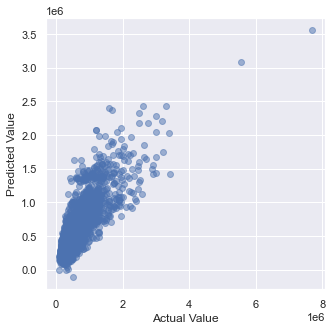

In [25]:
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")

This actually looks like it has a decently linear relationship, with only a few noteable outliers.

### Normality

C:\Users\shade\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


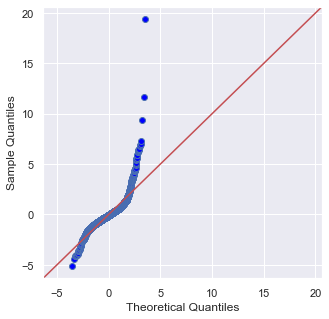

In [26]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

With the exception of some outliers, this plot does look relatively normal.

### Multicollinearity
We already made sure that our model did not violate multicollinearity by removing features in the modeling phase. But we check again in the interest of good practice.

In [27]:
vif = [variance_inflation_factor(X_train_final.values, i) for i in range(X_train_final.shape[1])]

pd.Series(vif, index=X_train_final.columns, name="Variance Inflation Factor")

sqft_living             5.137212
sqft_lot                1.575694
yr_built                2.001872
bedrooms                1.886433
bathrooms               3.510120
floors                  2.166562
renovated_2000          1.084002
waterfront              1.519392
has_basement            2.437871
view_EXCELLENT          1.673145
view_FAIR               1.179823
view_GOOD               1.249940
view_NONE              12.379873
grade_11_Excellent      1.219326
grade_12_Luxury         1.086037
grade_13_Mansion        1.017588
grade_4_Low             1.052859
grade_5_Fair            1.332819
grade_6_Low_Average     3.210529
grade_7_Average         7.760170
grade_8_Good            4.468256
grade_9_Better          2.251665
condition_Good          1.638350
condition_Very_Good     1.280188
Name: Variance Inflation Factor, dtype: float64

A feature with a vif above 5 generally points to it's strong influence on the multicollinearity opf the model. Someo of these features, however, can be explained by the fact that they are dummy variables of the categorical pieces of data from the preprocessing set. We will quickly test the RMSE of a similar model without these features.

In [28]:
hi_vif = ['view_NONE', 'sqft_living', 'grade_7_Average']

train_removed_vif = X_train_final.drop(hi_vif, axis=1)
test_removed_vif = X_test_final.drop(hi_vif, axis=1)

vif_removed = LinearRegression()

# Fit the model on X_train_final and y_train
vif_removed.fit(train_removed_vif, y_train)

vif_test = vif_removed.predict(test_removed_vif)
mean_squared_error(y_test, vif_test, squared=False)

247670.1959190852

Unfortunately, after testing this (in a few configurations), removing these high vif features only increases the RMSE.

### Homoscedasticity

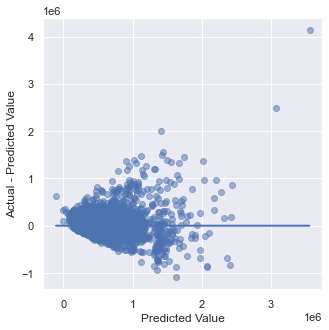

In [29]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test_final))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

Our model does not show the strongest homoscedacity, but it could be worse.

## Conclusions

This linear regression model certainly be used as a baseline predictor for assessing the value of homes in King County.

In [30]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

final_model_interpret = pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients")

print(final_model_interpret.sort_values(ascending=False))
print("Intercept:", final_model.intercept_)

grade_13_Mansion      1853454.022
grade_12_Luxury        905721.578
waterfront             571848.741
grade_11_Excellent     364974.794
view_EXCELLENT         233262.921
renovated_2000         107344.256
sqft_living            101414.772
view_FAIR               69429.326
condition_Very_Good     63734.593
view_GOOD               40540.435
bathrooms               22846.804
condition_Good          21372.995
has_basement            18945.643
floors                  11790.291
bedrooms               -16262.693
sqft_lot               -26530.229
view_NONE              -69349.403
yr_built               -84733.121
grade_9_Better        -231280.835
grade_8_Good          -410406.099
grade_7_Average       -508177.626
grade_4_Low           -550193.382
grade_6_Low_Average   -567311.303
grade_5_Fair          -612049.528
Name: Coefficients, dtype: float64
Intercept: 976799.8626844347


### Interpretation

The above shows how our model uses each feature to make determinations about the target price. 

The intercept is 976,799.86, which is the base value our model assumes each house is worth. Positive coefficients on features indicate the value each unit of that feature adds to the value, and negative coefficients indicate a decrease in house value due to that feature.

An example of a strongly positive coefficient is (unsurprisingly) square footage, with a coef of 101414. This means that the model predicts that with every unit of square footage, value should go up by $101,414. This holds true to common assumptions of what would be of value in a house. 

However, there also is a negative coefficient for features like bedrooms (with a coef of -16,262, meaning that every bedroom subtracts $16000 of value). This could be due to errors in the way our model was trained, or some inherent issues in the way that the modeling process works. 

### Next Steps
The reality is that there is a very broad range of factors that can influence any individual house sale. That being said, there are a multitude of ways we could explore futher. We could attempt to use the dataset where we converted some of the catgeorical variables into numerical scores. Or we could seek out additional outliers that may be negatively impacting our data. 

Furthermore, features like rating, view, and condition could use more exploration, since they are based on arbitrary human concepts. Features like whether or not a house was renovated, or even when it was renovated, also don't necessarily hold value if the type of renovations remain unknown. 

All in all, the model is a decent start to assess house cost, and could be used by the new real estate company to develop a baseling understanding. With additional reseaerch into more particulars of the data, and perhaps another investigation into houses based solely on location, the company could create an even more precise model.